In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# connect to mysql database
import mysql.connector
mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="",
    database="halofilkom_db"
)

# make cursor
mycursor = mydb.cursor()

In [24]:
# query
sql = "SELECT * FROM ost_canned_response"
mycursor.execute(sql)

# fetch all data
myresult = mycursor.fetchall()


# import sql result to pandas dataframe
import pandas as pd
df = pd.DataFrame(myresult)
df.drop(columns=[0,1,2,5,6,7,8],inplace=True) #drop kolom yang tidak diperlukan
df.columns = ['topik','jawaban']
df

,topik,jawaban
0,What is osTicket (sample)?,<p>osTicket is a widely-used open source suppo...
1,Sample (with variables),"<p>Hi %{ticket.name.first}, <br /><br /> Your ..."
2,Keuangan - Pengajuan Bantuan Keuangan,<p>Pengajuan Bantuan Keuangan dapat mengisi fo...
3,Keuangan - Pencairan Saldo UKT,<ol><li>Silahkan mengajukan permohonan pencair...
4,keuangan - cek siam untuk tagihan,"<p>Update Tagihan pada SIAM sdra, apabila Besa..."
...,...,...
121,Akademik_Alur Pasca Ujian Skripsi,<p>Panduan mahasiswa telah lulus Ujian Skripsi...
122,Akademik_Mhs Kritis Ujian sblm 21-07-2022 Yudi...,"<p>Terimakasih telah menghubungi HaloFilkom,<b..."
123,Akademik_Ujian Skripsi 2021-2 ; Pendaftaran yu...,"<p>Terimakasih telah menghubungi halofilkom, <..."
124,Akademik_templates DTIF,"<p>Terimakasih telah menghubungi halofilkom,<b..."


In [42]:
def findQuestionIndex(text):
    sql = "SELECT thread_id FROM ost_thread_entry where body like '%"+text+"%'"
    mycursor.execute(sql)
    myresult = mycursor.fetchall()
    return myresult

def findFirstQuestionWithIndex(index):
    sql = "SELECT body FROM ost_thread_entry where thread_id = "+str(index)
    mycursor.execute(sql)
    myresult = mycursor.fetchall()
    return myresult[0][0]

def findDateFirstQuestionWithIndex(index):
    sql = "SELECT created FROM ost_thread_entry where thread_id = "+str(index)
    mycursor.execute(sql)
    myresult = mycursor.fetchall()
    FirstDate = myresult[0][0]
    FirstDate = FirstDate.strftime("%Y-%m") # change datetime to string date
    return FirstDate

In [43]:
dfPertanyaan = pd.DataFrame(columns=['topik','pertanyaan','date'])
dfCount = pd.DataFrame(columns = ['topik','count'])

for i in range(len(df)):
    try:
        myresult = findQuestionIndex(df.loc[i]['jawaban'])
    
        # add data to dataframe
        if len(myresult) > 0:
            dfCount.loc[i,'topik'] = df.loc[i]['topik']
            dfCount.loc[i,'count'] = int(len(myresult))

            for question_id in myresult:
                q_id = question_id[0]
                q = findFirstQuestionWithIndex(q_id)
                q_date = findDateFirstQuestionWithIndex(q_id)
                dfPertanyaan.loc[len(dfPertanyaan)] = [df.loc[i]['topik'],q,q_date]
    except:
        print("error",sql)

error SELECT * FROM ost_canned_response


In [47]:
def detectCategoryTopik(topik):
    topik = topik.lower()
    if("akademik" in topik):
        return "Akademik"
    elif("kemahasiswaan" in topik):
        return "Kemahasiswaan"
    elif("keuangan" in topik):
        return "Keuangan"
    else:
        return "Lainnya"

In [52]:
df['kategori'] = df['topik'].apply(detectCategoryTopik)
dfPertanyaan['kategori'] = df['topik'].apply(detectCategoryTopik)

<AxesSubplot:>

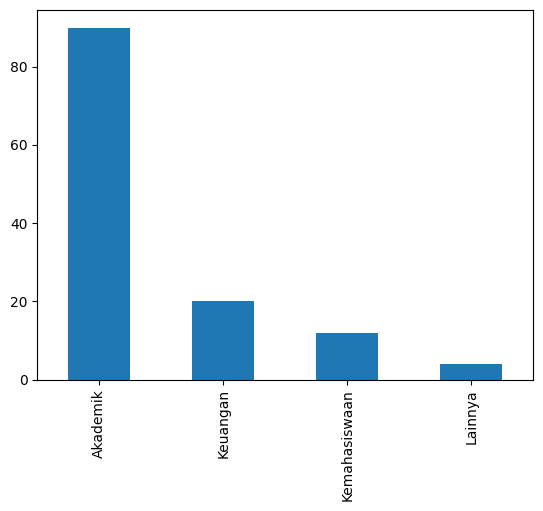

In [51]:
# plot column kategori in df
df['kategori'].value_counts().plot(kind='bar')

<AxesSubplot:>

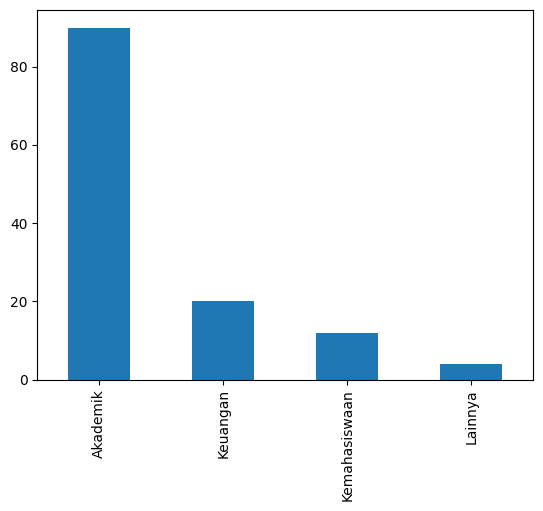

In [53]:
# plot dfPertanyaan kategori 
dfPertanyaan['kategori'].value_counts().plot(kind='bar')

In [64]:
dfPertanyaanGrouped = dfPertanyaan.groupby(['kategori','date'])['pertanyaan'].count()
dfPertanyaanGrouped

kategori       date   
Akademik       2021-08     8
               2021-09     2
               2021-10     4
               2021-11     8
               2021-12    16
               2022-01    21
               2022-02    15
               2022-03     3
               2022-04     1
               2022-05     1
               2022-06     6
               2022-07     5
Kemahasiswaan  2021-08    11
               2021-12     1
Keuangan       2021-08    16
               2021-09     1
               2021-10     2
               2022-01     1
Lainnya        2021-08     3
               2022-01     1
Name: pertanyaan, dtype: int64

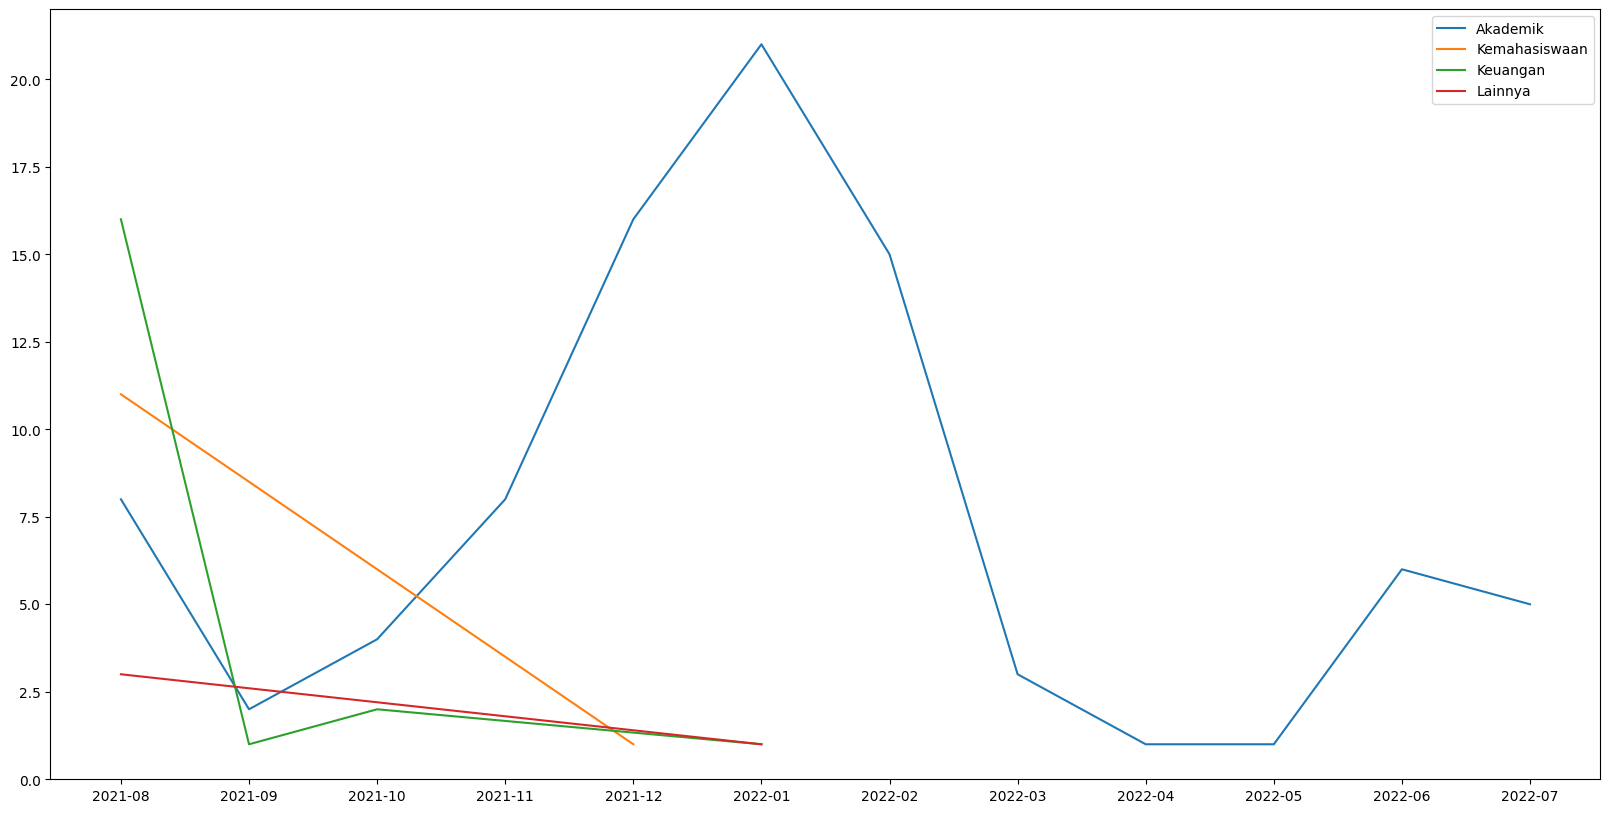

In [69]:
plt.figure(figsize=(20,10))
plt.plot(dfPertanyaanGrouped['Akademik'],label='Akademik')
plt.plot(dfPertanyaanGrouped['Kemahasiswaan'],label='Kemahasiswaan')
plt.plot(dfPertanyaanGrouped['Keuangan'],label='Keuangan')
plt.plot(dfPertanyaanGrouped['Lainnya'],label='Lainnya')
plt.legend()
plt.show()

In [7]:
dfCount.sort_values(by='count',ascending=False)

,topik,count
8,Keuangan : Tata Cara Pembayaran,110
5,Keuangan - Kriteria 50%,48
14,Kemahasiswaan - Tahapan pendaftaran Wisuda,35
4,keuangan - cek siam untuk tagihan,15
117,PSIK : Permasalahan telah diproses (Tiket ditu...,11
114,Akademik_KKN 2020,9
19,Keuangan - Angsur SAP,7
31,Akademik : Surat Aktif Kuliah,7
89,Akademik ; Bantuan UKT,5
49,Akademik_Pengajuan proposal skripsi di luar ja...,5


<AxesSubplot:xlabel='topik'>

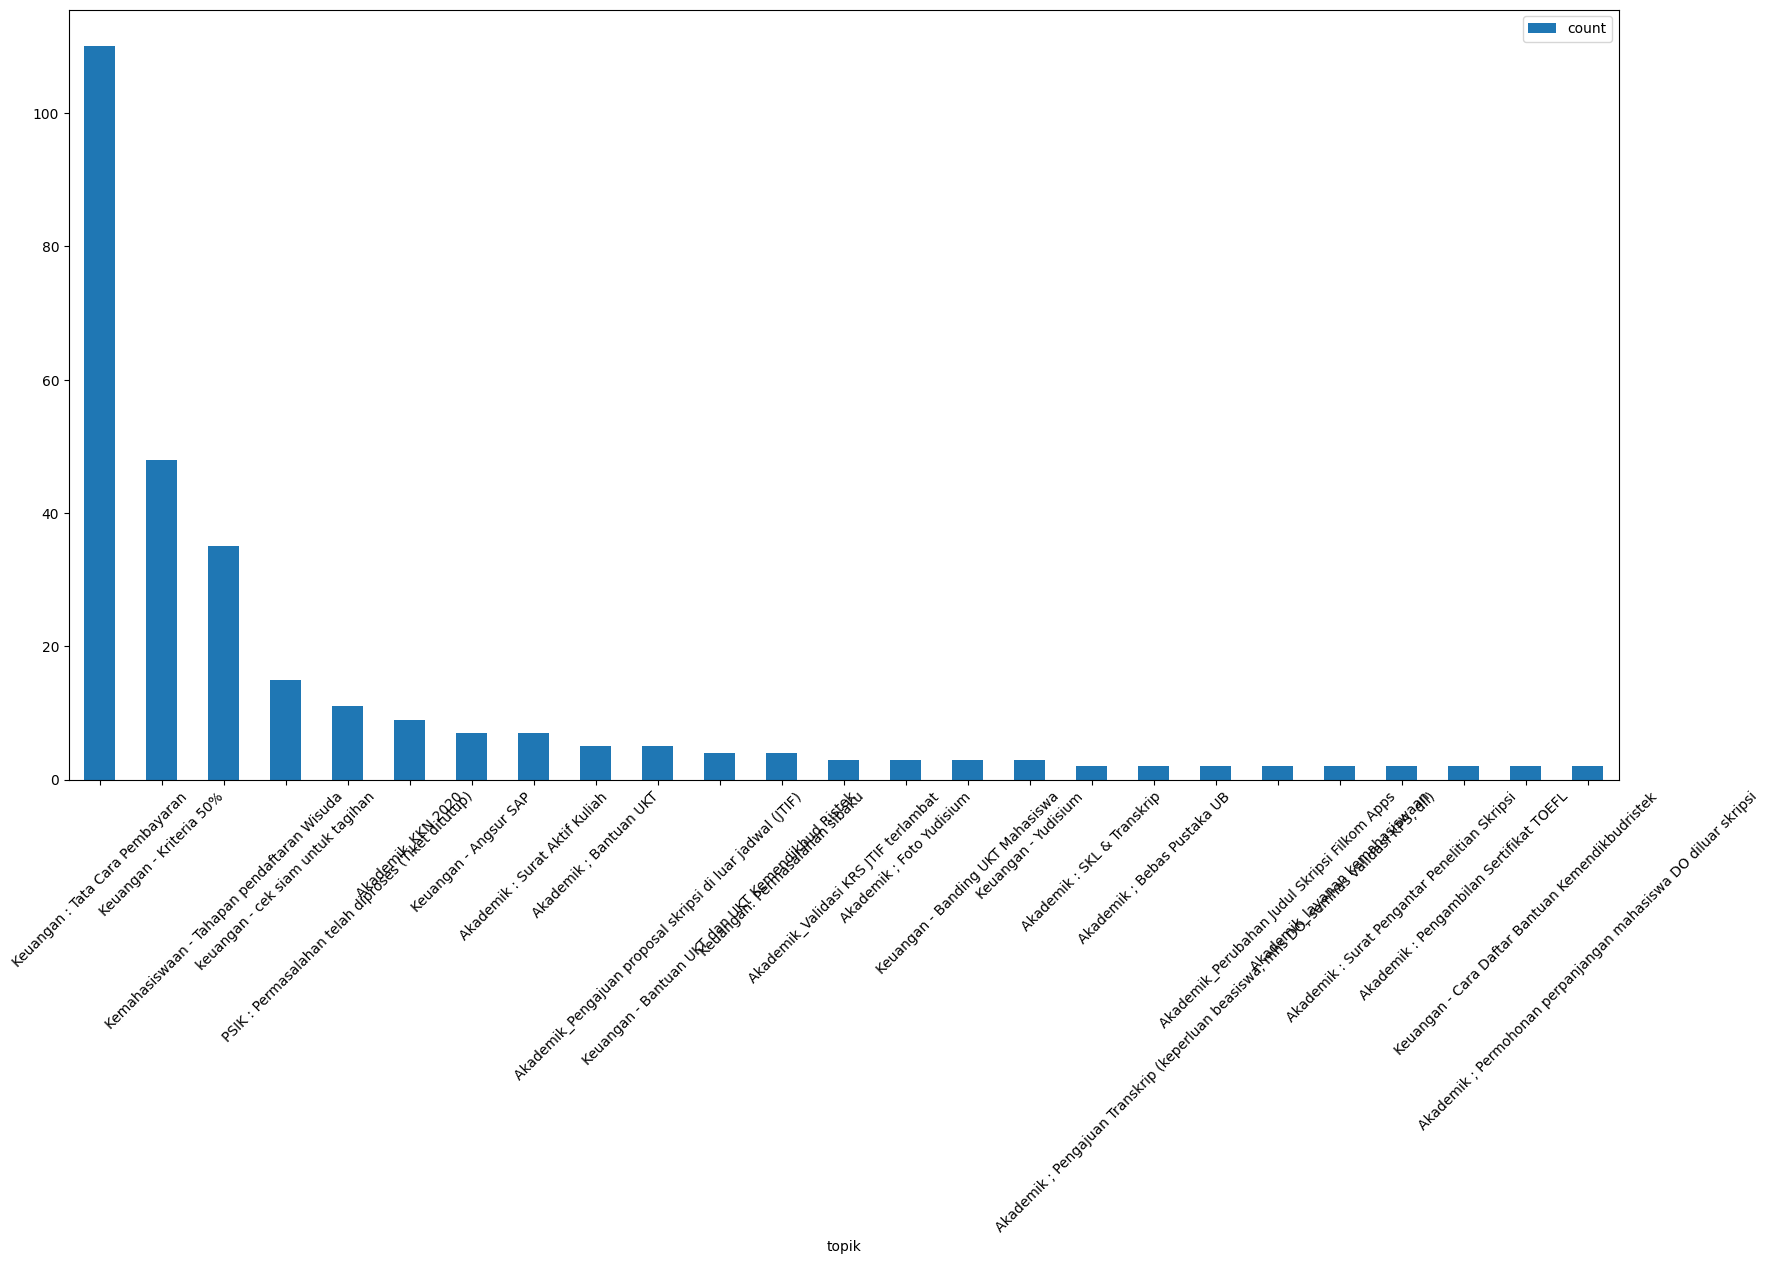

In [8]:
# plot top 25 and annotate
dfCount.sort_values(by='count',ascending=False).head(25).plot(kind='bar',x='topik',y='count',figsize=(20,10), rot=45)

In [28]:
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# import nltk stopword indonesia from stopword_list.txt
stop_words = []
with open('stopword_list.txt') as f:
        stop_words = f.read().splitlines()

def removeStopwords(text):
        text = text.split(' ')
        text = [x for x in text if x not in stop_words]
        return ' '.join(text)

def stemSentence(sentence):
        return stemmer.stem(sentence)

def cleanTag(text):
        text = text.replace('<p>','').replace('</p>','').replace('<ol>','').replace('</ol>','').replace('<li>','').replace('</li>','').replace('<ul>','').replace('</ul>','').replace('<br>','').replace('br','').replace('<strong>','').replace('</strong>','').replace('<em>','').replace('</em>','').replace('<a href="','').replace('">','').replace('</a>','').replace('<img src="','').replace('" alt="','').replace('" />','').replace('< />','').replace('\xa0','')
        return text

def cleanText(text):
        text = cleanTag(text)
        text = stemSentence(text)
        text = removeStopwords(text)
        return text

In [34]:
dfPertanyaan['topik'] = dfPertanyaan['topik'].apply(lambda x: cleanTag(x))

<AxesSubplot:ylabel='Frequency'>

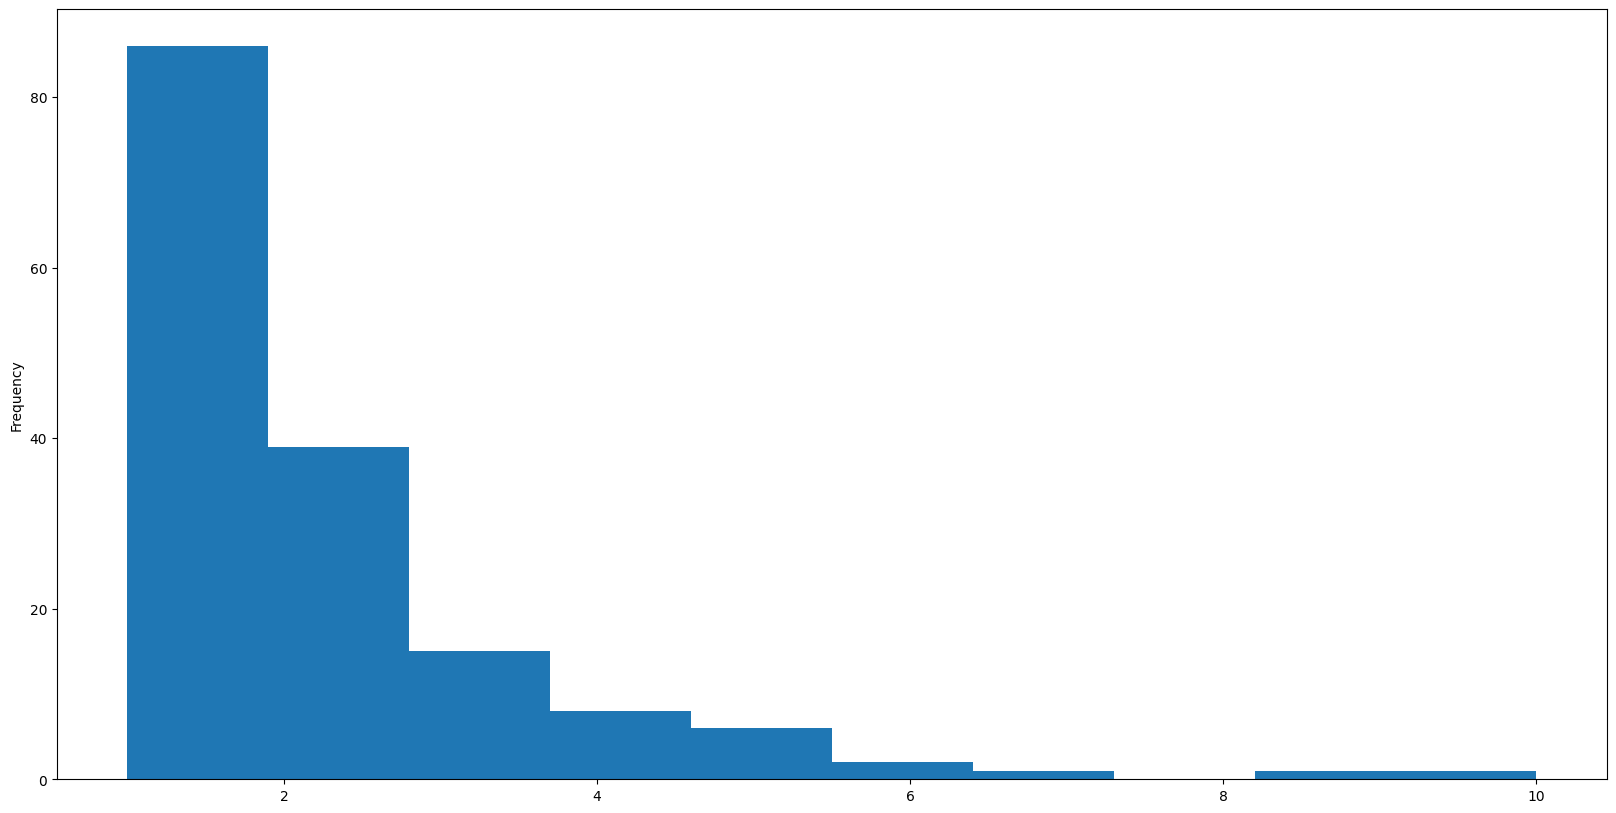

In [41]:
# plot the question asked in time series
dfPertanyaan['date'] = pd.to_datetime(dfPertanyaan['date'])
dfPertanyaan['date'].groupby(dfPertanyaan['date']).count().plot(kind='line',figsize=(20,10))


In [35]:
dfPertanyaan

,topik,pertanyaan,date
0,keuangan - cek siam untuk tagihan,<p>Kepada Yth. Pimpinan Fakultas Ilmu Komputer...,2021-08-05
1,keuangan - cek siam untuk tagihan,<p>Yth</p> <p>Wakil Dekan II Bidang Keuangan</...,2021-08-05
2,keuangan - cek siam untuk tagihan,"<p>Jakarta, 05 Agustus 2021</p> <p>Kepada Yth....",2021-08-05
3,keuangan - cek siam untuk tagihan,"<p>Assalamualaikum Wr.wb</p> <p>Selamat Siang,...",2021-08-06
4,keuangan - cek siam untuk tagihan,"<p>Jakarta, 05 Agustus 2021</p> <p>Kepada Yth....",2021-08-05
...,...,...,...
304,PSIK : Permasalahan telah diproses (Tiket ditu...,"<p>Selamat pagi, saya ingin mengupload dokumen...",2022-07-26
305,PSIK : Permasalahan telah diproses (Tiket ditu...,<p>Selamat pagi Bapak/Ibu. Maaf mengganggu wak...,2022-07-28
306,PSIK : Permasalahan telah diproses (Tiket ditu...,"<p>Jadi, awalnya saya harus mengupload jurnal ...",2022-08-01
307,Akademik_nilai MBKM belum keluar 2021-2,<p>Saya saat ini sedang mengalami masalah yang...,2022-07-14


# Intent Classificaation

In [24]:
intents = dict()
intents['intents'] = []


In [25]:
for topik in dfCount['topik']:
    patterns = []
    for i in range(len(dfPertanyaan)):
        if dfPertanyaan.loc[i]['topik'] == topik:
            patterns.append(cleanTag(dfPertanyaan.loc[i]['pertanyaan']))
    response = cleanTag(df.loc[df['topik'] == topik]['jawaban'].values[0])
    
    intents['intents'].append({
        'tag': topik,
        'patterns': patterns,
        'responses': [response]
    })

In [26]:
salam_intent = {
            "tag":"sapaan",
            "patterns": [
                "halo",
                "selamat siang",
                "selamat malam",
                "selamat pagi",
                "salam"
            ],
            "responses": [
                "Halo, saya disini HaloFILKOM Bot akan membantu anda dalam menjawab pertanyaan anda untuk urusan kemahasiswaan dan akademik."
            ]
        }
intents['intents'].append(salam_intent)

penutup_intent = {
            "tag":"penutup",
            "patterns": [
                "terima kasih",
                "menjawab",
                "sudah menjawab",
                "cukup"
            ],
            "responses": [
                "Terima kasih telah menggunakan layanan HaloFILKOM Bot, jika ada hal hal yang ingin ditanyakan lebih lanjut jangan ragu menghubungi saya lagi. Have a good day."
            ]
        }
intents['intents'].append(penutup_intent)


no_res_intent = {
            "tag":"no_response",
            "patterns": [],
            "responses": [
                "Pertanyaan belum saya kenali... silahkan menghubungi unit terkait untuk menjawab pertanyaan tersebut di HaloFILKOM. Anda juga dapat menambahkan pertanyaan anda pada <a href='https://s.ub.ac.id/tanyafilkombot' target='_blank'>laman berikut</a> untuk membantu mengembangkan sistem ini"
            ]
        }
intents['intents'].append(no_res_intent)

In [27]:
# extract to json
import json
with open('intents_newV2.json', 'w') as outfile:
    json.dump(intents, outfile)